## Imports

In [74]:
import pandas as pd
import numpy as np
import json
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error

## File Extraction - Amazon Data

In [75]:
file_path = '../DataInputs/Weekly/amazon_weekly_close.json' # path of json file

# Load JSON data from file
with open(file_path, 'r') as file:
    data = json.load(file)

# Convert data to pandas DataFrame
df = pd.DataFrame(list(data.items()), columns=['Date', 'Close'])
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = df['Close'].astype(float)
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)


## Splitting Dataset - Training & Test

- train_df, used for training the ARIMA model
- test_df, used for comparing the prediction the model makes to the values in test df

In [76]:
# Split the data into training and test sets
train_df = df[df.index <= '2023-03-31']
test_df = df[(df.index >= '2023-03-31') & (df.index <= '2023-05-26')] # use to test the model and compare at the end


# Check the last date in the training set and the first date in the test set
print("Last date in training set:", train_df.index[-1])
print("First date in test set:", test_df.index[0])

# Check the last few rows of the training set
print(train_df.tail())

#training data set is now the main dataframe
df = train_df.copy()

# Check the first few rows of the test set
print(test_df.head())


Last date in training set: 2023-03-31 00:00:00
First date in test set: 2023-03-31 00:00:00
             Close
Date              
2023-03-03   94.90
2023-03-10   90.73
2023-03-17   98.95
2023-03-24   98.13
2023-03-31  103.29
             Close
Date              
2023-03-31  103.29
2023-04-06  102.06
2023-04-14  102.51
2023-04-21  106.96
2023-04-28  105.45


## Training Dataset Graph

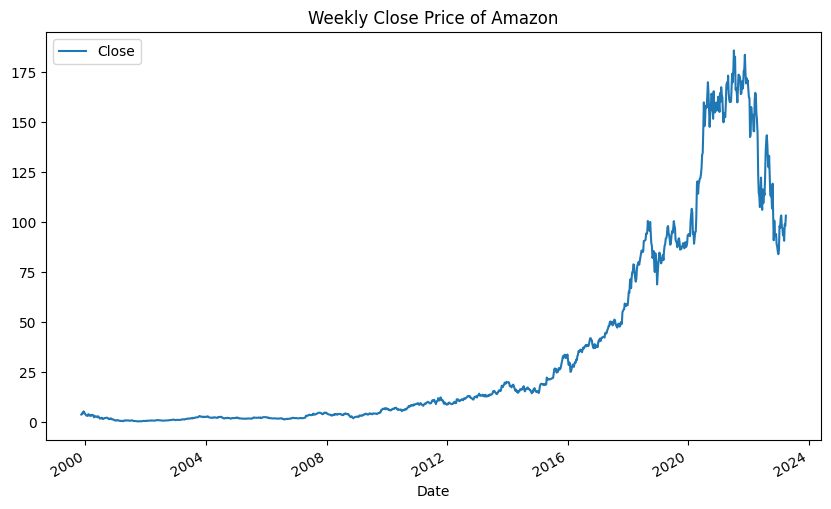

In [77]:
df.plot(figsize=(10,6))
plt.title('Weekly Close Price of Amazon')
plt.show()

## Checking Stationarity 

In [78]:
result = adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.462745
p-value: 0.899084


## Differencing 

This makes the dataset stationary

In [79]:
# Assuming the series is not stationary, differencing is needed
df_diff = df.diff().dropna()

# Check stationarity again
result = adfuller(df_diff['Close'])
print('p-value after differencing: %f' % result[1])


p-value after differencing: 0.000000


## ACF & PACF

ACF and PACF plots are crucial for determining the parameters (p, d, q) for ARIMA models. The p and q parameters can be estimated from PACF and ACF plots, respectively.


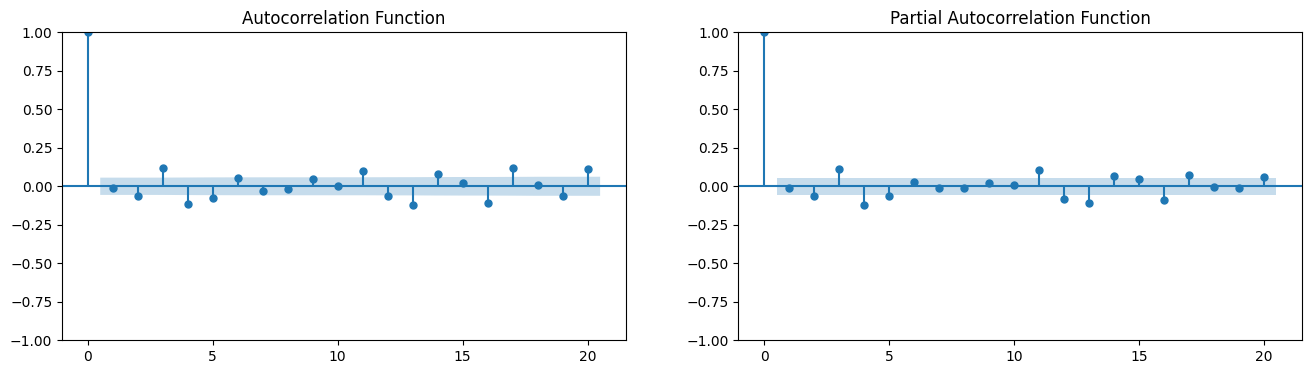

In [80]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# ACF
plot_acf(df_diff['Close'], ax=ax1, lags=20)
ax1.set_title('Autocorrelation Function')

# PACF
plot_pacf(df_diff['Close'], ax=ax2, lags=20)
ax2.set_title('Partial Autocorrelation Function')

plt.show()


## Making the ARIMA Model - p, d, q selection

In [81]:
# Assuming 'df' is your DataFrame and it's indexed by date
start_date = df.index.min()  # or replace with the specific start date string

# Set the frequency to weekly, starting on the start_date
df.index = pd.date_range(start=start_date, periods=len(df), freq='W-FRI')

# Replace p, d, q with your chosen values
model = ARIMA(df['Close'], order=(3,2,1))

results = model.fit()

# Summary of the model
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1221
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -2930.077
Date:                Mon, 15 Jan 2024   AIC                           5870.154
Time:                        16:48:11   BIC                           5895.683
Sample:                    11-12-1999   HQIC                          5879.763
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -9.355e-05      0.012     -0.008      0.994      -0.023       0.023
ar.L2         -0.0588      0.013     -4.669      0.000      -0.083      -0.034
ar.L3          0.1171      0.013      8.744      0.0

## Model Diagnostics

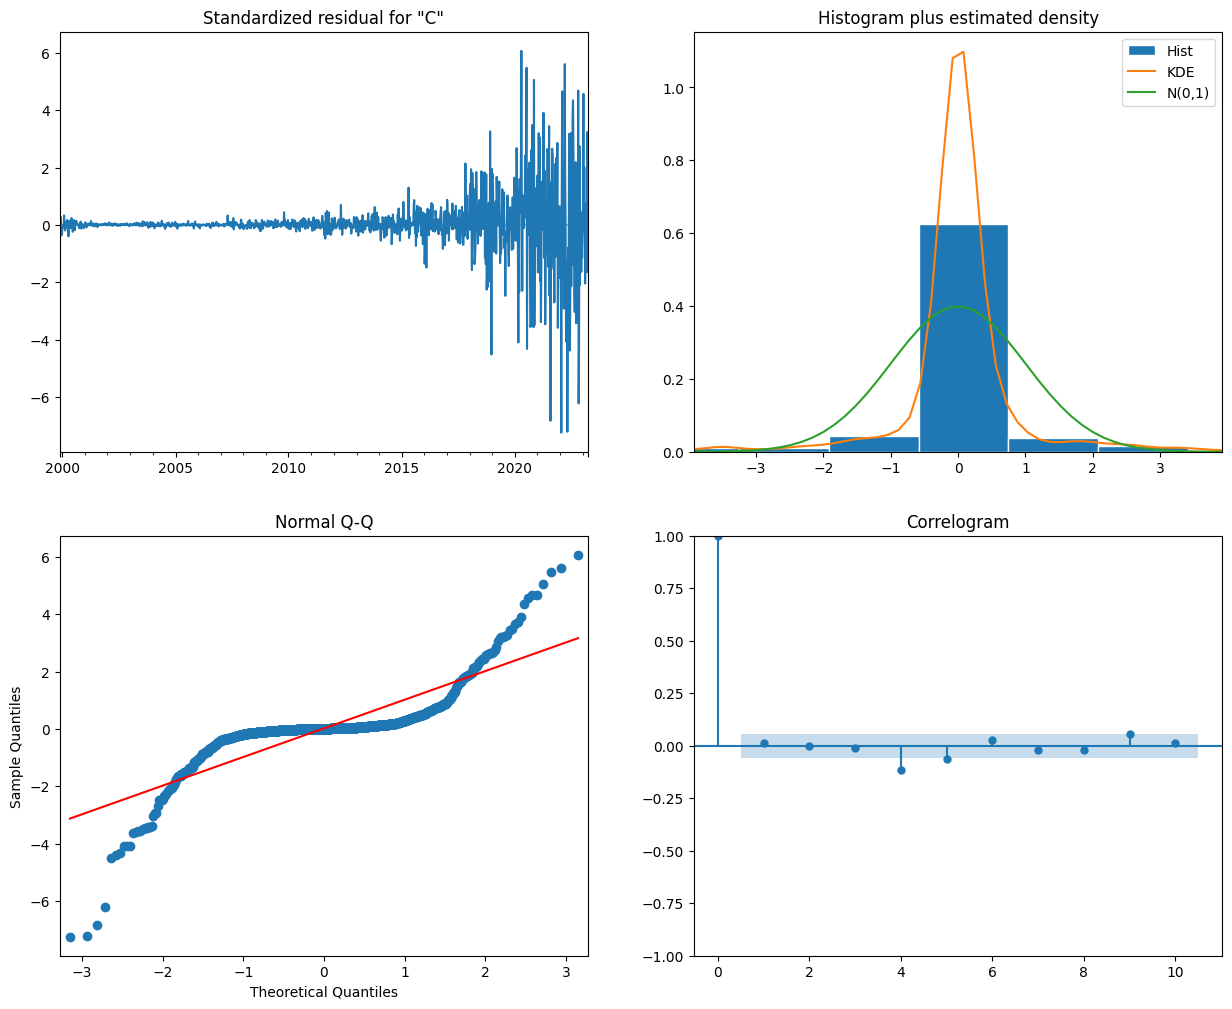

In [82]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


## Prediction Graph

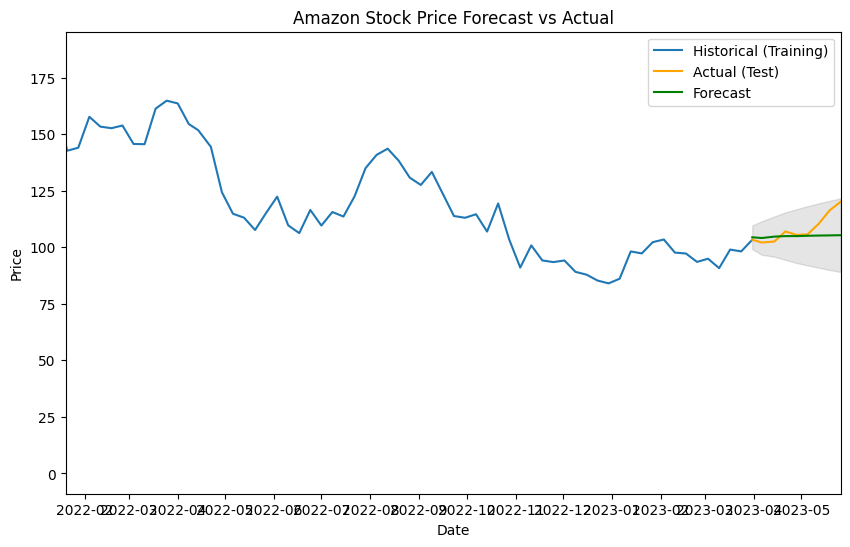

In [89]:
# Number of steps to forecast is the length of the test set
n_steps = len(test_df)

# Generate out-of-sample forecasts
forecast = results.get_forecast(steps=n_steps)
forecast_index = test_df.index  # Use the test set dates for the forecast index

# Confidence intervals
forecast_ci = forecast.conf_int()

# Plotting the forecast along with the test set
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Close'], label='Historical (Training)')
plt.plot(test_df.index, test_df['Close'], label='Actual (Test)', color='orange')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='green')
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='k', alpha=0.1)

                 # Set the xlim to show data from July 2023 onwards
plt.xlim([pd.Timestamp('2022-01-20'), test_df.index[-1]])

# (Optional) Set the format of the x-axis to better display the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))


plt.title('Amazon Stock Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## RMSE & MAE

In [84]:
predicted_values = forecast.predicted_mean
actual_values = test_df['Close']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("Root Mean Squared Error: ", rmse)

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)
print("Mean Absolute Error: ", mae)


Root Mean Squared Error:  6.515152161333078
Mean Absolute Error:  4.381418825875834


## Optimising

In [85]:
import pmdarima as pm

# Using auto_arima to find the best ARIMA model with a wider range of parameters
best_model = pm.auto_arima(train_df['Close'],
                           seasonal=True,  # assuming the data could be seasonal
                           m=52,           # weekly data, so m might be 52 for yearly seasonality
                           stepwise=True,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           max_p=5, max_q=5, max_d=2,
                           max_P=2, max_Q=2, max_D=1)

print(best_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=43.59 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=5881.955, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=5883.720, Time=6.47 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=5884.020, Time=8.11 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=5881.076, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=5881.773, Time=3.90 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=5882.083, Time=5.00 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=5880.794, Time=11.52 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=5877.257, Time=103.21 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=5875.258, Time=40.36 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=5877.192, Time=54.76 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=5877.183, Time=58.32 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AIC=5878.067, Time=158.62 sec
 ARIMA(0,1,0)(2,0,0)[52]             : AIC=5874.153, Time=14.26 sec
 ARIMA(0,1,0)(

## Optimised Graph

c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


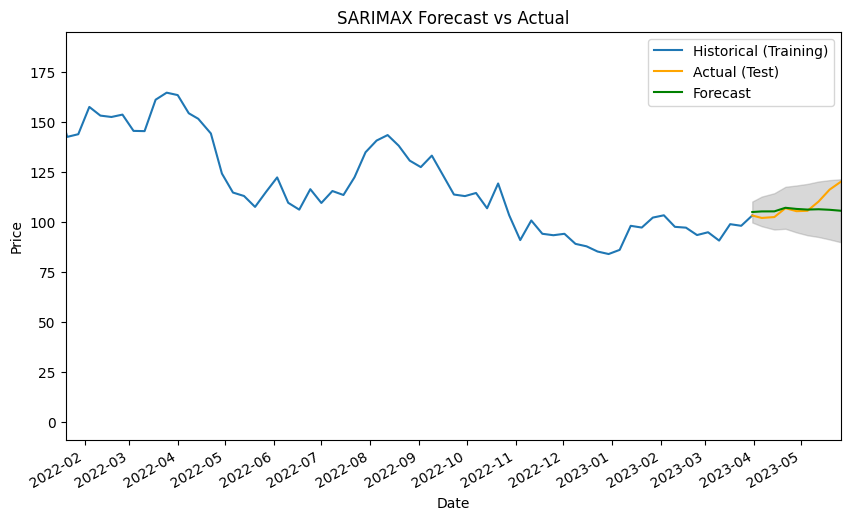

In [86]:
# Forecast with the best SARIMAX model
n_periods = len(test_df)
forecast, conf_int = best_model.predict(n_periods=n_periods, return_conf_int=True)

# Plot the forecast with confidence intervals
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Close'], label='Historical (Training)')
plt.plot(test_df.index, test_df['Close'], label='Actual (Test)', color='orange')
plt.plot(test_df.index, forecast, label='Forecast', color='green')
plt.fill_between(test_df.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], color='grey', alpha=0.3)

# Set the xlim to show data from July 2023 onwards
plt.xlim([pd.Timestamp('2022-01-20'), test_df.index[-1]])

# (Optional) Set the format of the x-axis to better display the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.title('SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the date labels for better readability
plt.gcf().autofmt_xdate()

plt.show()


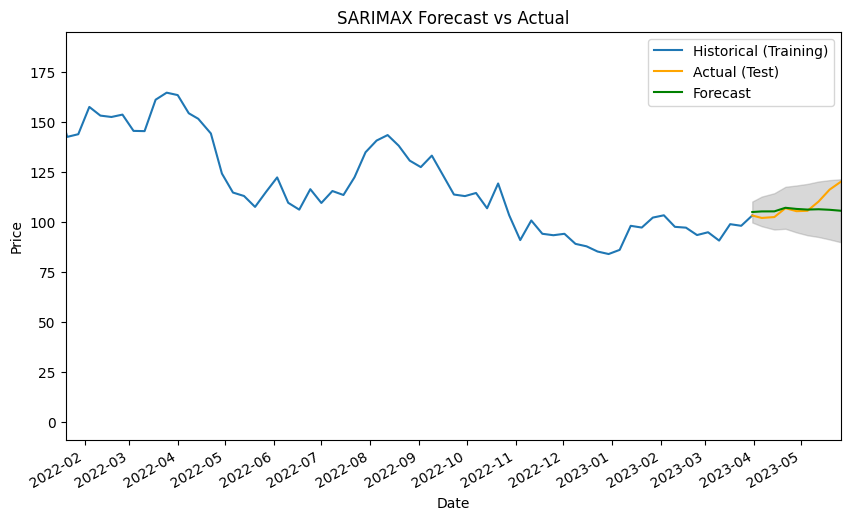

In [87]:
import matplotlib.dates as mdates

# Plot the forecast with confidence intervals
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Close'], label='Historical (Training)')
plt.plot(test_df.index, test_df['Close'], label='Actual (Test)', color='orange')
plt.plot(test_df.index, forecast, label='Forecast', color='green')
plt.fill_between(test_df.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], color='grey', alpha=0.3)

# Set the xlim to show data from July 2023 onwards
plt.xlim([pd.Timestamp('2022-01-20'), test_df.index[-1]])

# (Optional) Set the format of the x-axis to better display the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.title('SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the date labels for better readability
plt.gcf().autofmt_xdate()

plt.show()


## Optimised RSME & MAE

In [88]:
# Generating the forecast for the entire duration of the test set
forecast, conf_int = best_model.predict(n_periods=n_steps, return_conf_int=True)

# Make sure the forecast_index aligns with the forecast length
# This should be equivalent to the test set index length
forecast_index = test_df.index

# Now the predicted_values should have the same length as the actual_values
predicted_values = forecast

# Actual values from the test set
actual_values = test_df['Close']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("Root Mean Squared Error: ", rmse)

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)
print("Mean Absolute Error: ", mae)


Root Mean Squared Error:  6.225531875934967
Mean Absolute Error:  4.239214190545955


c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
